In [1]:
# importing core 
# aqui empacotamos as funções que dá pra achar no código do Kevin Systrom
from core import run_full_model, plot_rt, plot_standings

# imports básicos
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# importando joblib para rodar em paralelo
from joblib import Parallel, delayed

# para plots com uma melhor resolução
%config InlineBackend.figure_format = 'retina'

In [2]:
dataSourceURL = 'https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv'

sc_city_df = (
    pd.read_csv(dataSourceURL, parse_dates=['date'])
    .rename(columns={'totalCases':'confirmed_total',
                     'newCases': 'confirmed_new',
                     'deaths': 'deaths_total',
                     'newDeaths': 'deaths_new'})
    .query('state == "SC"')
    .drop(['ibgeID','country','state'], axis=1)
)

In [3]:
# filtrando por determinadas cidades
not_in_clause_filter = ['CASO SEM LOCALIZAÇÃO DEFINIDA/SC']
sc_city_df = sc_city_df[~sc_city_df['city'].isin(not_in_clause_filter)]

#in_clause_filter = ['Florianópolis/SC', 'Blumenau/SC', 'Joinville/SC', 'Balneário Camboriú/SC', 'Camboriú/SC', 'Criciúma/SC']
#sc_city_df = sc_city_df[sc_city_df['city'].isin(in_clause_filter)]

In [4]:
N_CITIES_TO_PLOT_RT = 20

In [5]:
cities_to_plot = sc_city_df.groupby(['city']).sum()
cities_to_plot = cities_to_plot.sort_values(by=['confirmed_new'], ascending=False)
cities_to_plot = cities_to_plot.head(N_CITIES_TO_PLOT_RT)
cities_to_plot = cities_to_plot.index.tolist()


In [6]:
sc_city_df = sc_city_df.groupby(['city','date']).sum()

# para a análise, vamos usar somente novos casos confirmados
sc_city_df = sc_city_df['confirmed_new']

# listando os municipios
#for grp in sc_top_cities_df.groupby(level='city'):
#    print(grp)

In [7]:
# número de cores para paralelizar modelo nos estados
N_JOBS = -1

In [8]:
### running posteriors ###
with Parallel(n_jobs=N_JOBS) as parallel:
    results = parallel(delayed(run_full_model)(grp[1], sigma=0.01) for grp in sc_city_df.groupby(level='city'))

In [9]:
# precisei remover as séries vazias
results[:] = [serie for serie in results if serie.empty == False]
final_results = pd.concat(results)

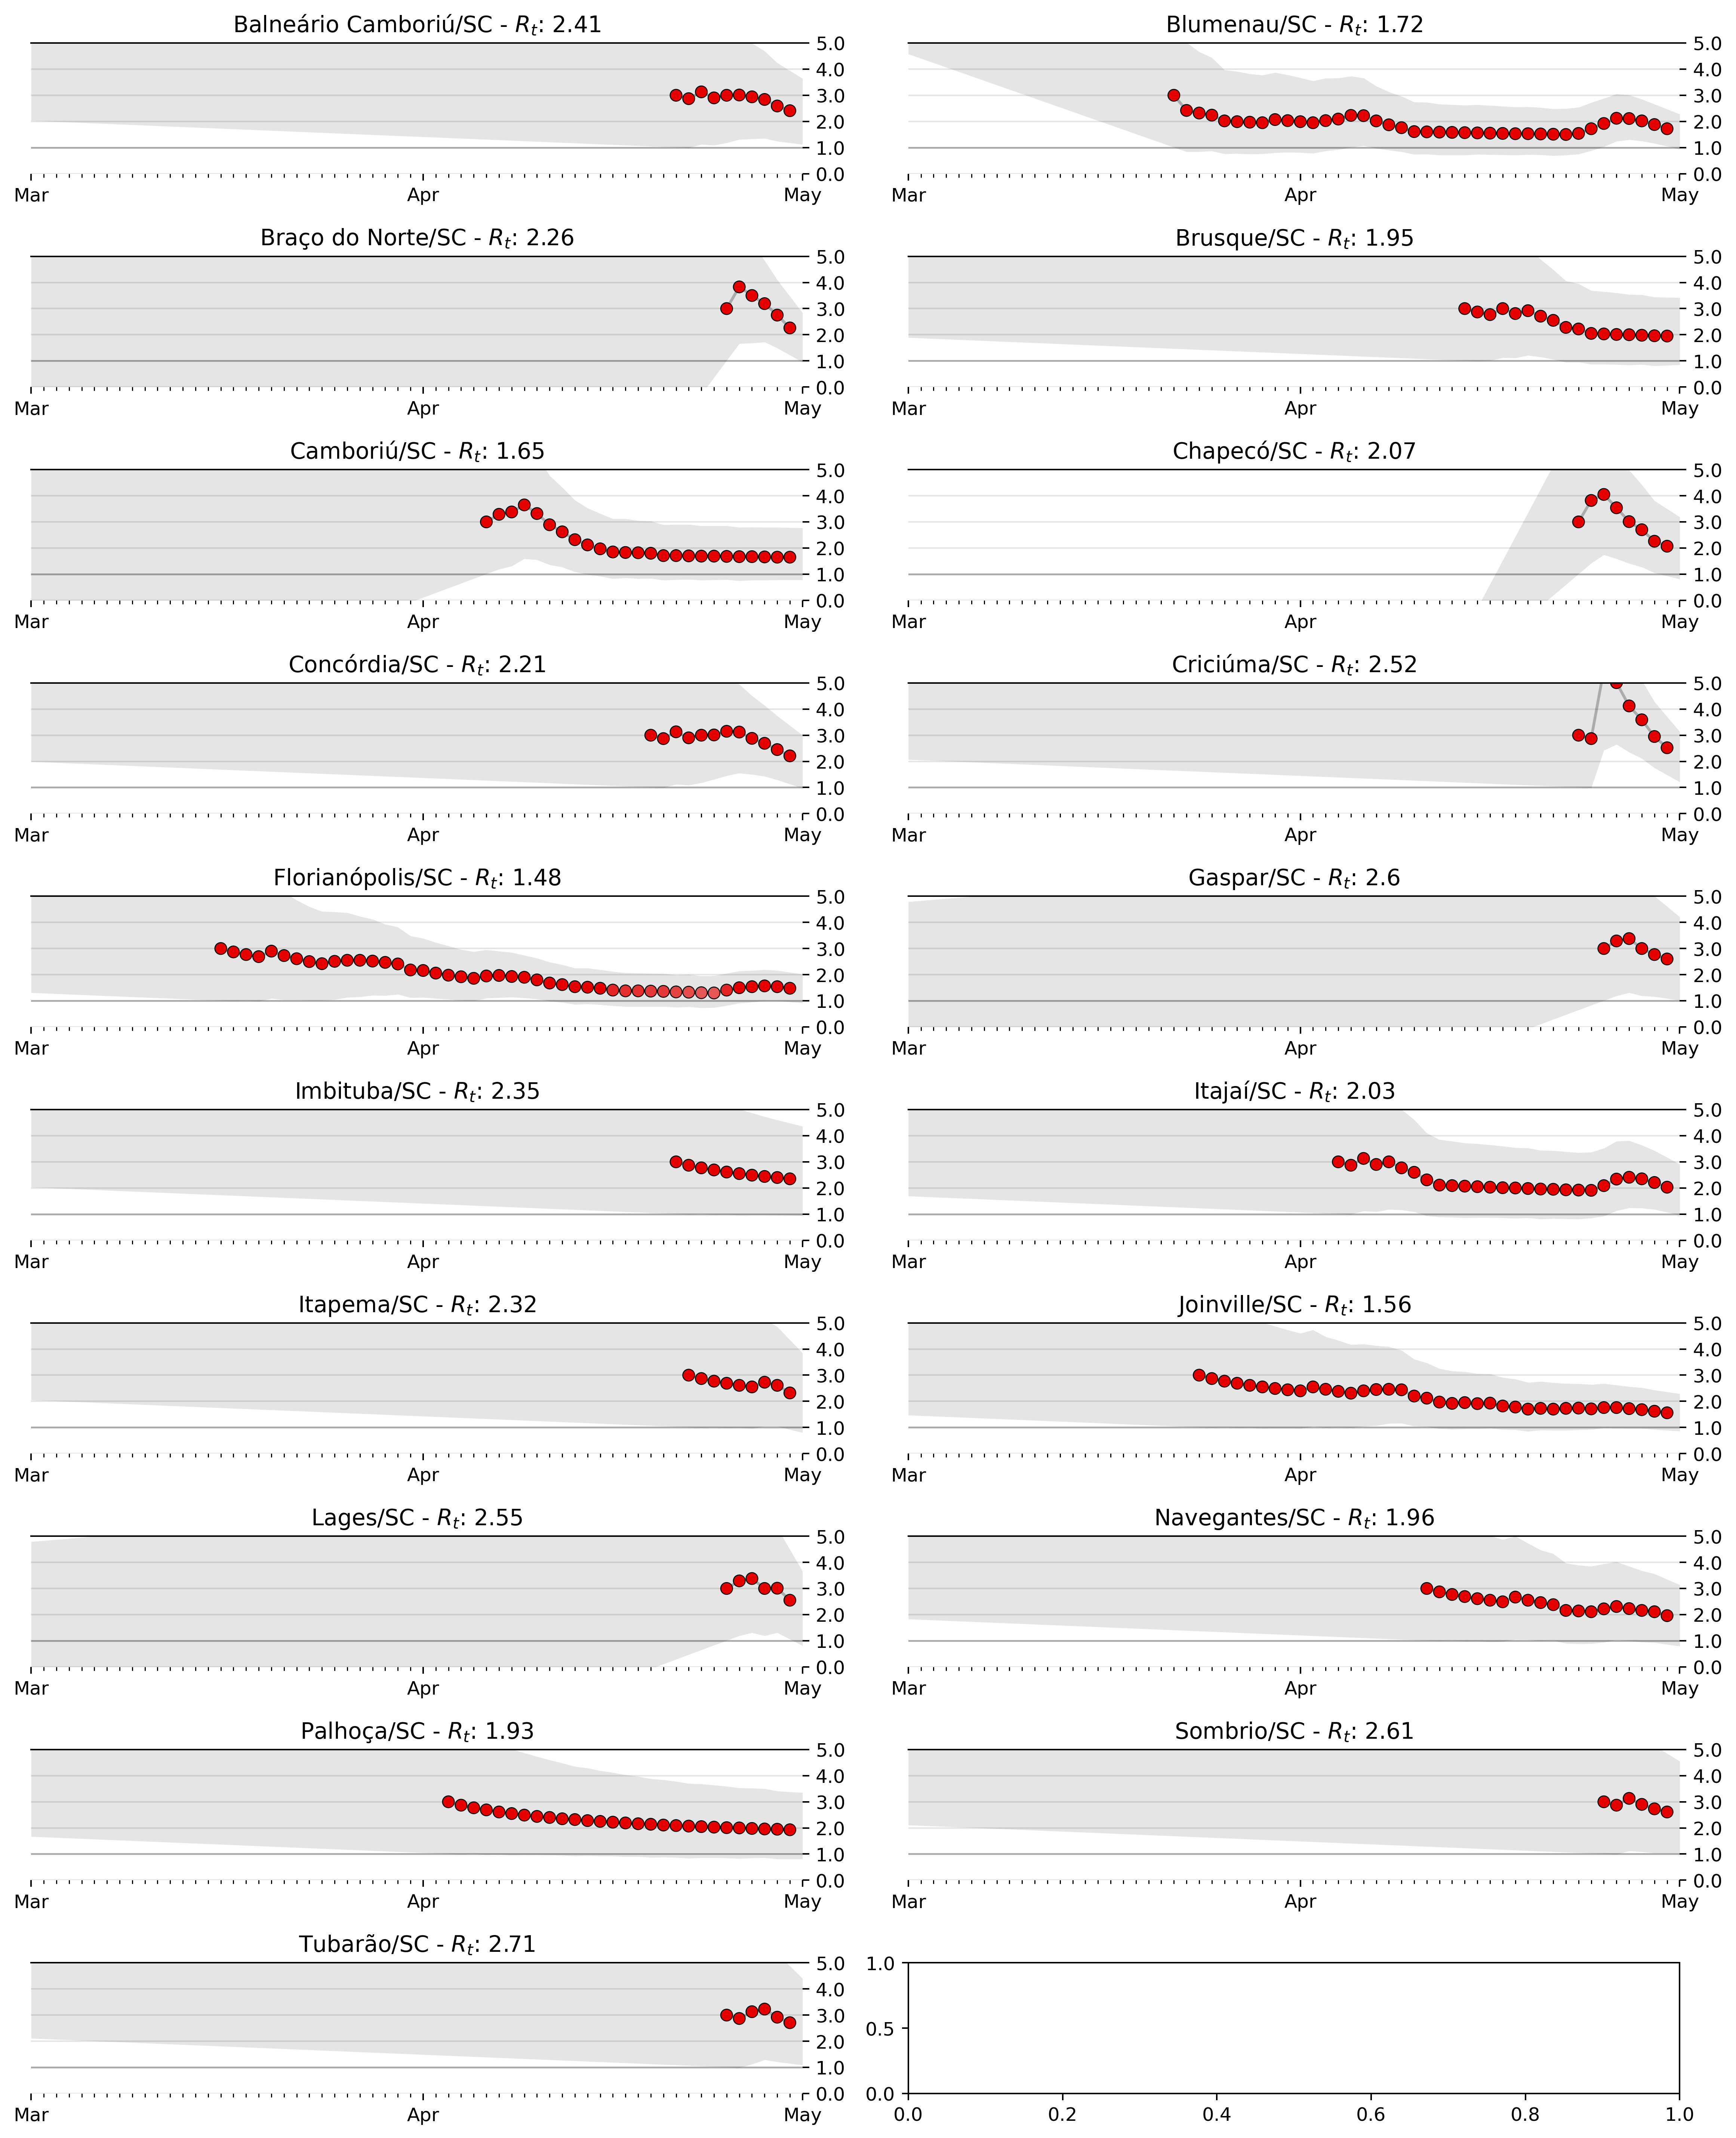

In [10]:
def plot_rt_locations():

    # number of columns and rows for plotting
    N_COLS = 2
    N_ROWS = 10

    # opening figura
    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(13, 16), dpi=180)

    # loop for several states
    index = 0
    for i, (location_name, result) in enumerate(final_results.groupby('city')):
        if location_name in cities_to_plot:
            current_rt = str(round(result.tail(1)['ML'].values[0], 2))
            title = f"{location_name} - $R_t$: {current_rt}"
            plot_rt(result, axes.flat[index], title)
            index += 1

    # saving figure
    fig.tight_layout()
    fig.set_facecolor('w')

plot_rt_locations()

(<Figure size 1950x900 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2d1975e4788>)

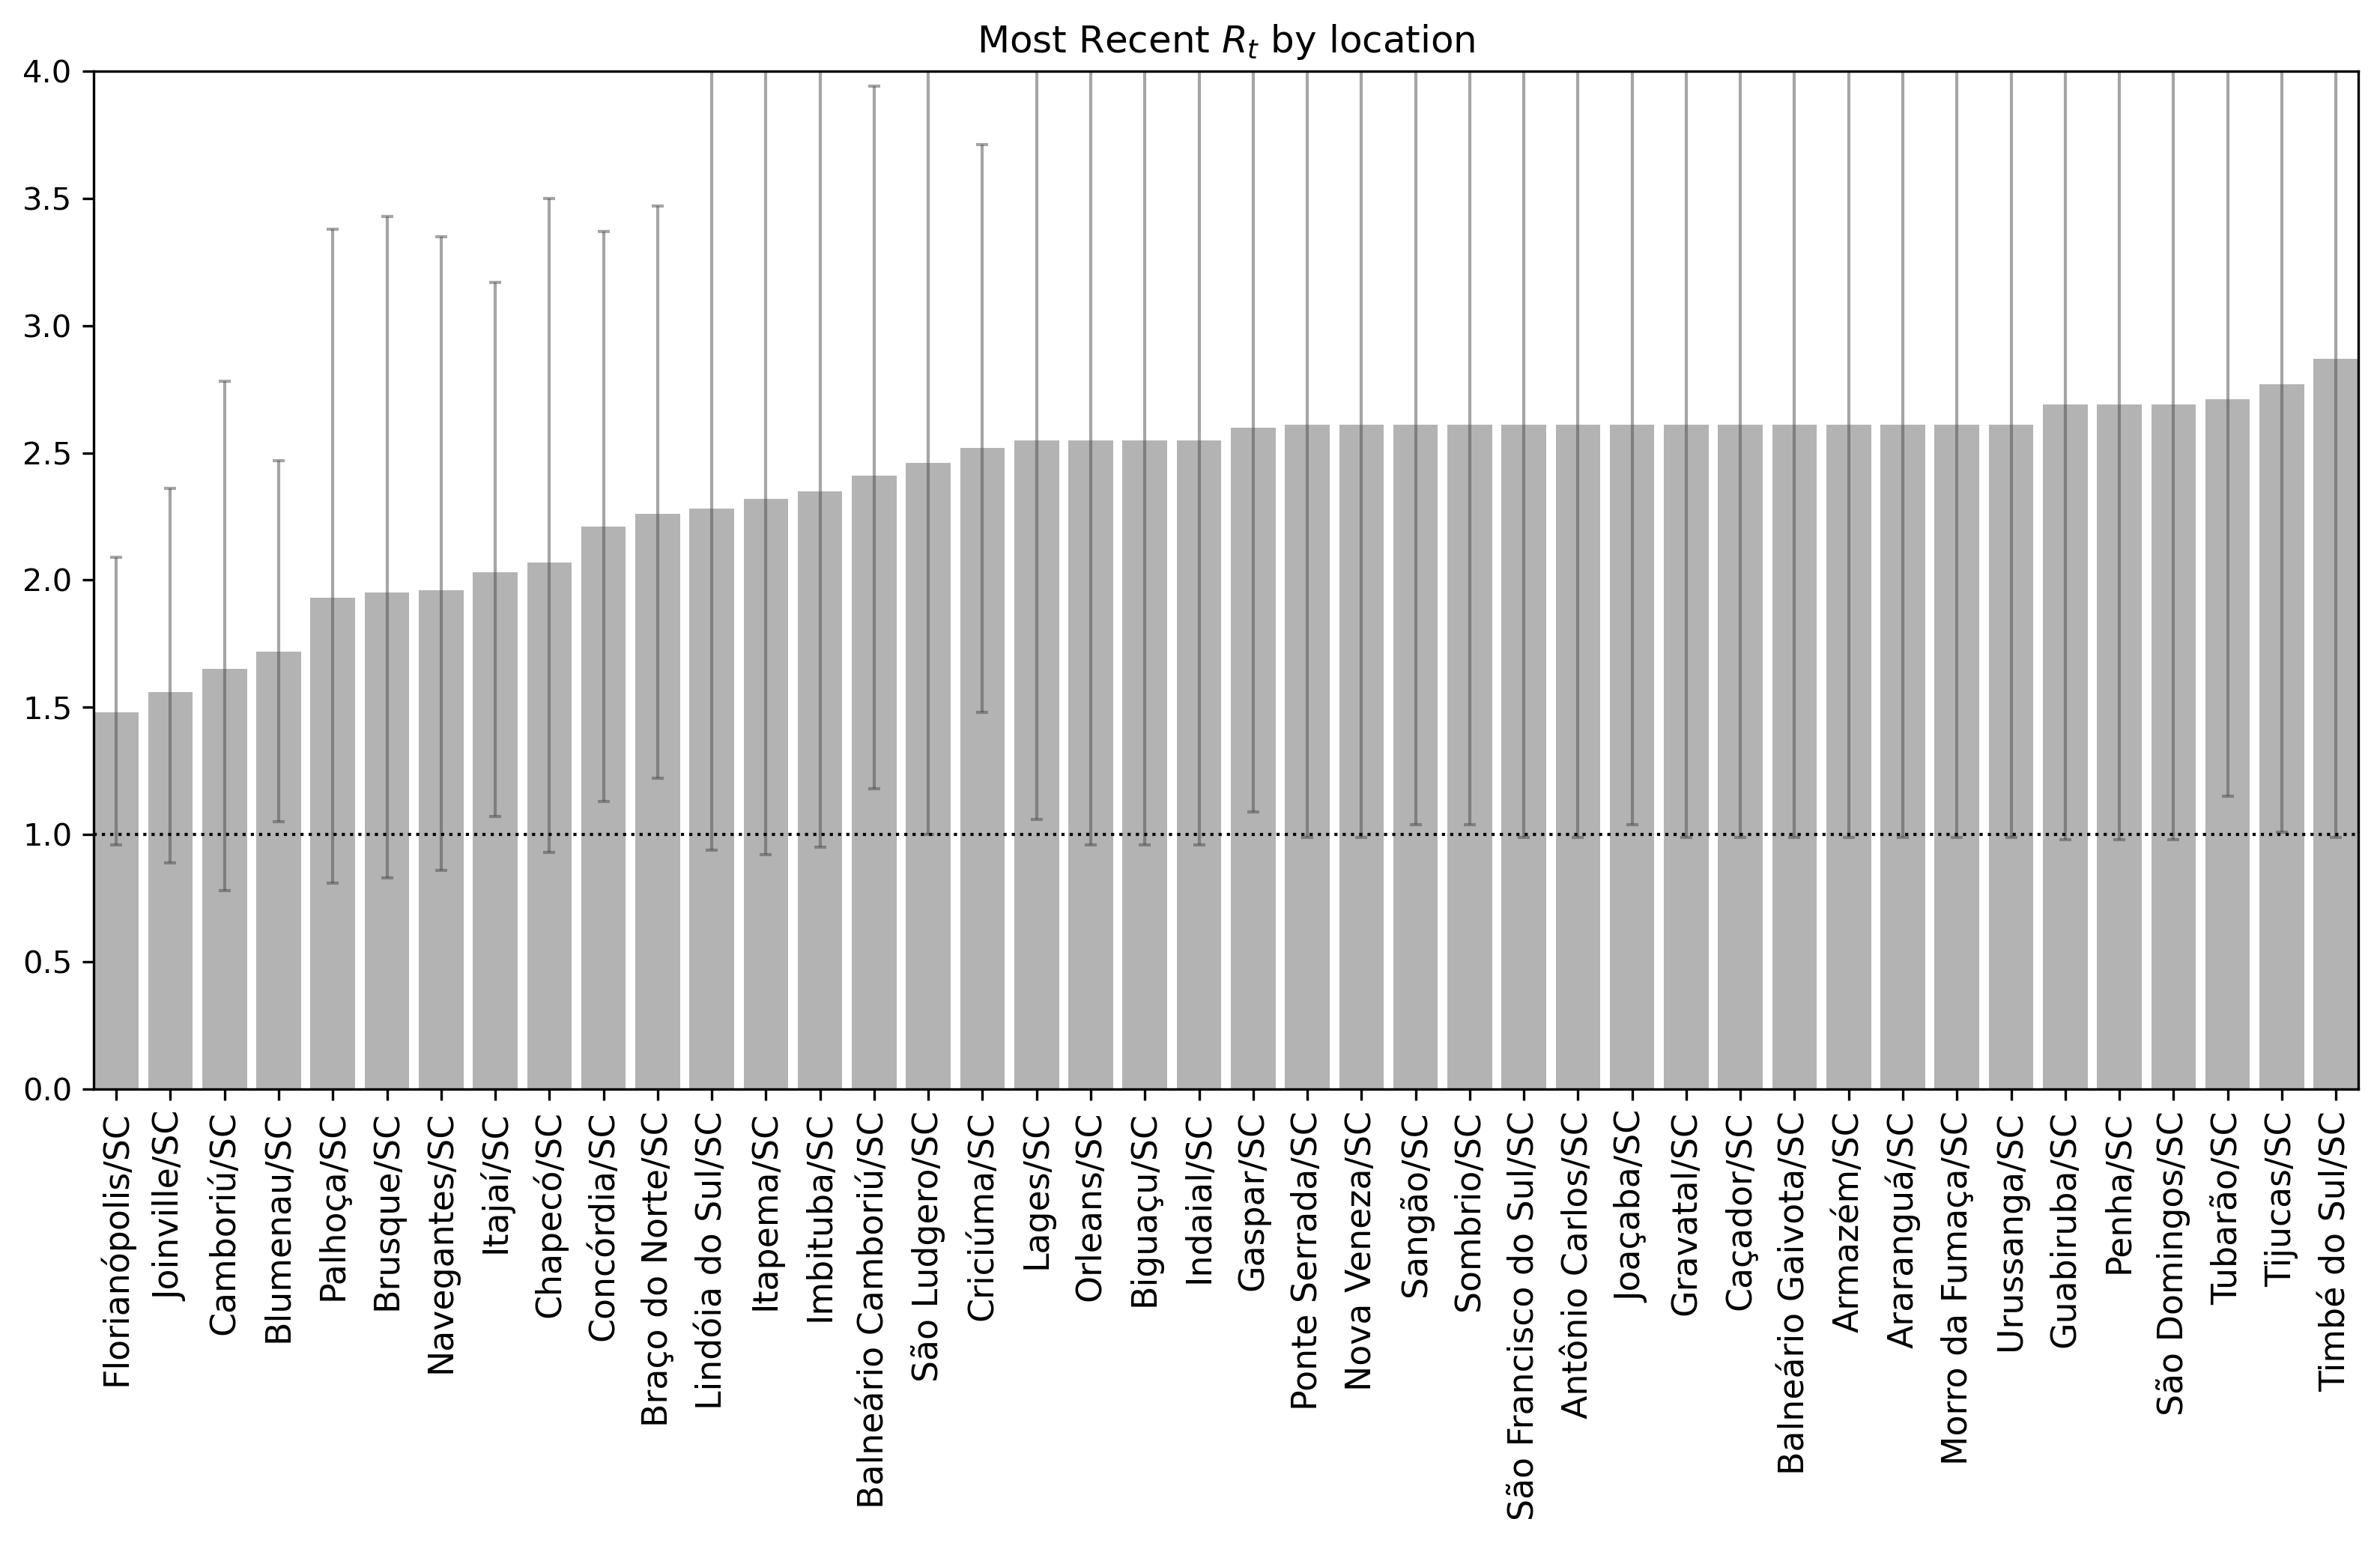

In [11]:
### plotting - state comparison ###

mr = final_results.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()
mr.sort_values('ML', inplace=True)
plot_standings(mr, figsize=(13,6))